In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Load the dataset
file_path = './data/Training.csv'
data = pd.read_csv(file_path)

In [3]:
# Inspect the dataset
print(data.head())
print(f"Dataset shape: {data.shape}")

   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             

In [4]:
# Separate features (symptoms) and target (prognosis)
X = data.drop(columns=["prognosis"], axis=1)  # Features: all columns except "prognosis"
y = data["prognosis"]  # Target: "prognosis"

In [5]:
# Encode target labels (prognosis)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
from sklearn.utils import class_weight

# Add class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [8]:
# Define the model architecture
from tensorflow.keras.layers import Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(41, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\Luthfi Hanif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[early_stopping]
)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1447 - loss: 3.4558 - val_accuracy: 0.9634 - val_loss: 1.6614
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 1.6558 - val_accuracy: 1.0000 - val_loss: 0.2267
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.7029 - val_accuracy: 1.0000 - val_loss: 0.0507
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9090 - loss: 0.4185 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9315 - loss: 0.3029 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.9361 - loss: 0.2648 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9505 - loss: 0.2042 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9604 - loss: 0.1537 - val_accuracy: 

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 2.0033817236253526e-06
Test Accuracy: 1.0


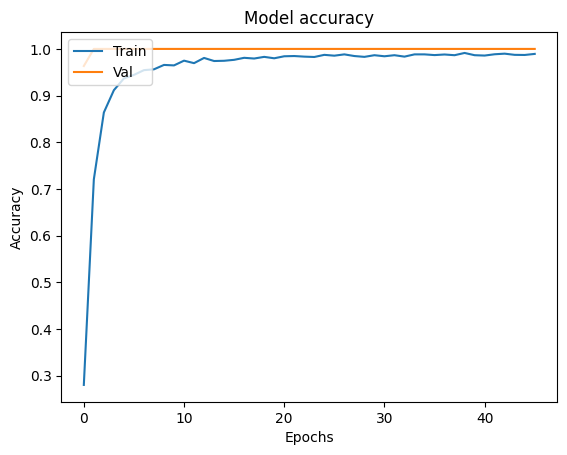

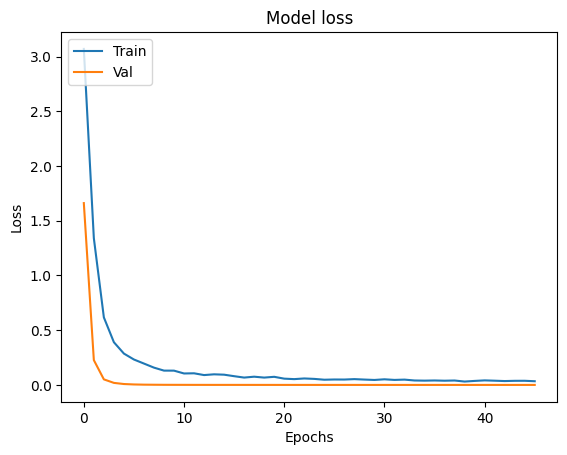

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [12]:
# Define the list of all possible symptoms from the dataset
symptom_columns = X.columns.tolist()

def predict_disease(input_symptoms, model, symptom_columns, label_encoder):
    # Initialize a feature array with zeros
    input_features = np.zeros(len(symptom_columns), dtype=int)
    
    # Map the input symptoms to their respective indices and set them to 1
    for symptom in input_symptoms:
        if symptom in symptom_columns:
            index = symptom_columns.index(symptom)
            input_features[index] = 1
        else:
            print(f"Warning: Symptom '{symptom}' not found in the symptom list.")
    
    # Reshape the input features for prediction
    input_features = input_features.reshape(1, -1)
    
    # Make a prediction
    prediction = model.predict(input_features)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    
    # Decode the predicted class index to get the disease name
    predicted_disease = label_encoder.inverse_transform([predicted_class_index])[0]
    
    return predicted_disease

# List of symptoms
user_symptoms = ['joint_pain', 'neck_pain', 'knee_pain', 'hip_joint_pain']

# Predict the disease
predicted_disease = predict_disease(user_symptoms, model, symptom_columns, label_encoder)

# Output the prediction
print(f"Predicted Disease: {predicted_disease}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Disease: Osteoarthristis
